## Initial Data Cleaning ##

Collects and unifies primary and secondary school data where the anonymized student is present in both.

In [1]:
import csv
import os
import pandas as pd
import numpy as np

In [2]:
# Check files in the Raw Data folder
os.listdir('../Data/Raw')

['Avaluacio_de_quart_dEducacio_Secundaria_Obligatoria_20251113.csv',
 'Avaluacio_de_sise_deducacio_primaria_20251113.csv']

In [3]:
#csv_path = os.path.abspath("../Data/Raw/Avaluacio_de_quart_dEducació_Secundaria_Obligatoria_20251111.csv")

# GENERAL OPTION: Take the first file in the Raw Data folder
csv_path = os.path.join('../Data/Raw', os.listdir('../Data/Raw')[0])

secondary_data = []
with open(csv_path) as data: 
    reader = csv.reader(data)
    for row in reader:
        secondary_data.append(row)
    data.close()
df_S = pd.DataFrame(secondary_data)

# Second file in the Raw Data folder
csv_path = os.path.join('../Data/Raw', os.listdir('../Data/Raw')[1])
primary_data = []
with open(csv_path) as data: 
    reader = csv.reader(data)
    for row in reader:
        primary_data.append(row)
    data.close()
df_P = pd.DataFrame(primary_data)

In [4]:
df_P.columns = df_P.iloc[0]    # set first row as header
df_P = df_P[1:]                # drop the first row (since it's now the header)
df_P.reset_index(drop=True, inplace=True)

df_S.columns = df_S.iloc[0]    # set first row as header
df_S = df_S[1:]                # drop the first row (since it's now the header)
df_S.reset_index(drop=True, inplace=True)

In [5]:
df = pd.DataFrame({'CODI_ALUMNE': pd.concat([df_P['CODI_ALUMNE'], df_S['CODI_ALUMNE']]).unique()})
df['in_P'] = df['CODI_ALUMNE'].isin(df_P['CODI_ALUMNE']) 
df['in_S'] = df['CODI_ALUMNE'].isin(df_S['CODI_ALUMNE'])
matching = df[df['in_P'] & df['in_S']] 

# Keep only rows from df_P where CODI_ALUMNE exists in both
df_P_matching = df_P[df_P['CODI_ALUMNE'].isin(matching['CODI_ALUMNE'])].copy()
# Keep only rows from df_S where CODI_ALUMNE exists in both
df_S_matching = df_S[df_S['CODI_ALUMNE'].isin(matching['CODI_ALUMNE'])].copy()

df_P_matching.reset_index(drop=True, inplace=True)
df_S_matching.reset_index(drop=True, inplace=True)

In [6]:
common_cols = set(df_P_matching.columns) & set(df_S_matching.columns)

In [7]:
print(df_P.columns)
print(df_S.columns)

Index(['ANY', 'CODI_ALUMNE', 'PCAT', 'PCAT_CL', 'PCAT_EE', 'PCAST', 'PCAST_CL',
       'PCAST_EE', 'PMAT', 'PMAT_NC', 'PMAT_EFM', 'PMAT_CR', 'PANG', 'PANG_CO',
       'PANG_CE', 'PFRAN', 'PFRAN_CO', 'PFRAN_CE', 'PANG_EE', 'PFRAN_EE',
       'PCAT_CO', 'PCAST_CO', 'PMED', 'PMED_COMP1', 'PMED_COMP2', 'PMED_COMP3',
       'GENERE', 'MES_NAIXEMENT', 'ANY_NAIXEMENT', 'AREA_TERRITORIAL',
       'NATURALESA', 'HABITAT'],
      dtype='object', name=0)
Index(['ANY', 'CODI_ALUMNE', 'PCAT', 'PCAT_CL', 'PCAT_EE', 'PCAST', 'PCAST_CL',
       'PCAST_EE', 'PANG', 'PANG_CO', 'PANG_CL', 'PANG_EE', 'PFRAN',
       'PFRAN_CO', 'PFRAN_CL', 'PFRAN_EE', 'PMAT', 'PMAT_EFM', 'PMAT_CR',
       'PMAT_EST', 'PMAT_NC', 'PALE', 'PALE_CO', 'PALE_CL', 'PALE_EE', 'PCIEN',
       'PCIEN_COMP1', 'PCIEN_COMP2', 'PCIEN_COMP3', 'PCIEN_COMP4', 'GENERE',
       'MES_NAIXEMENT', 'ANY_NAIXEMENT', 'NATURALESA', 'AREA TERRITORIAL',
       'HABITAT'],
      dtype='object', name=0)


In [8]:
# List of required columns (from your message)
required_cols = [
    'ANY', 'ANY_NAIXEMENT', 'CODI_ALUMNE', 'GENERE', 'HABITAT',
    'MES_NAIXEMENT', 'NATURALESA', 'PANG', 'PANG_CO', 'PANG_EE',
    'PCAST', 'PCAST_CL', 'PCAST_EE', 'PCAT', 'PCAT_CL', 'PCAT_EE',
    'PFRAN', 'PFRAN_CO', 'PFRAN_EE', 'PMAT', 'PMAT_CR', 'PMAT_EFM', 'PMAT_NC'
]

df_P_clean = df_P.dropna(subset=required_cols).copy()
df_S_clean = df_S.dropna(subset=required_cols).copy()

common_ids = set(df_P_clean['CODI_ALUMNE']) & set(df_S_clean['CODI_ALUMNE'])
df_P_clean = df_P_clean[df_P_clean['CODI_ALUMNE'].isin(common_ids)]
df_S_clean = df_S_clean[df_S_clean['CODI_ALUMNE'].isin(common_ids)]

df_P_clean['snapshot'] = 'past'
df_S_clean['snapshot'] = 'present'

df_combined = pd.concat([df_P_clean, df_S_clean], ignore_index=True)

df_pivot = df_combined.pivot_table(
    index='CODI_ALUMNE',
    columns='snapshot',
    values=[col for col in required_cols if col != 'CODI_ALUMNE'],
    aggfunc='first'
)

In [9]:
df_pivot

0             ANY         ANY_NAIXEMENT         GENERE          \
snapshot     past present          past present   past present   
CODI_ALUMNE                                                      
             2018    2019          2005              H       D   
100028145    2018    2022          2005    2005      D       D   
1000332771   2016    2020          2004    2004      H       H   
1000343103   2016    2020          2004    2004      D       D   
1000354325   2016    2020          2004    2004      D       D   
...           ...     ...           ...     ...    ...     ...   
999005478    2016    2020          2004    2004      H       H   
999027032    2016    2020          2004    2004      H       H   
99949376     2016    2020          2004    2004      D       D   
99961597     2019    2023          2007    2007      H       H   
99983150     2018    2022          2006    2006      D       D   

0                      HABITAT                    MES_NAIXEMENT          ...  \
snapshot                  past            present          past present  ...   
CODI_ALUMNE                                                              ...   
                MÃ©s de 100000     MÃ©s de 100000             1          ...   
100028145       MÃ©s de 100000     MÃ©s de 100000             7       7  ...   
1000332771   De 10001 a 100000  De 10001 a 100000             1       1  ...   
1000343103   De 10001 a 100000  De 10001 a 100000             1       1  ...   
1000354325   De 10001 a 100000  De 10001 a 100000            10      10  ...   
...                        ...                ...           ...     ...  ...   
999005478    De 10001 a 100000  De 10001 a 100000            11      11  ...   
999027032    De 10001 a 100000  De 10001 a 100000             9       9  ...   
99949376        MÃ©s de 100000     MÃ©s de 100000             7       7  ...   
99961597        MÃ©s de 100000     MÃ©s de 100000             7       7  ...   
99983150        MÃ©s de 100000     MÃ©s de 100000            10      10  ...   

0           PFRAN_EE           PMAT         PMAT_CR         PMAT_EFM          \
snapshot        past present   past present    past present     past present   
CODI_ALUMNE                                                                    
                              91,49          100,00            81,82           
100028145                     76,89   43,33   88,89   66,67    81,82   33.33   
1000332771                    91,59    79,8  100,00   88,89    91,67      70   
1000343103                    97,28   74,88  100,00   77,78   100,00      90   
1000354325                    94,20    97,5  100,00     100    83,43      90   
...              ...     ...    ...     ...     ...     ...      ...     ...   
999005478                     82,39   45,08   88,49   22,22    75,34      20   
999027032                     82,84   59,48   88,49   66,67    91,43      30   
99949376                      97,09   82,82  100,00   88,89    91,67      90   
99961597                      81,57   70,86   77,78    87,5    81,82    62.5   
99983150                      90,79   49,17   88,89   33,33    90,91   33.33   

0           PMAT_NC          
snapshot       past present  
CODI_ALUMNE                  
              92,86          
100028145     57,14       0  
1000332771    84,30   71,43  
1000343103    92,22   42,86  
1000354325   100,00     100  
...             ...     ...  
999005478     84,23   71,43  
999027032     69,41   85,71  
99949376     100,00   85,71  
99961597      85,71   55,56  
99983150      92,86    62,5  

[251748 rows x 44 columns]

In [10]:
df_pivot.shape[0]

251748

In [11]:
matching.shape[0]

251748

In [12]:
common_cols

{'ANY',
 'ANY_NAIXEMENT',
 'CODI_ALUMNE',
 'GENERE',
 'HABITAT',
 'MES_NAIXEMENT',
 'NATURALESA',
 'PANG',
 'PANG_CO',
 'PANG_EE',
 'PCAST',
 'PCAST_CL',
 'PCAST_EE',
 'PCAT',
 'PCAT_CL',
 'PCAT_EE',
 'PFRAN',
 'PFRAN_CO',
 'PFRAN_EE',
 'PMAT',
 'PMAT_CR',
 'PMAT_EFM',
 'PMAT_NC'}

In [13]:
# One-to-one merge by CODI_ALUMNE eliminating duplicates

print("df_P_matching: files =", len(df_P_matching),
      " unique students =", df_P_matching['CODI_ALUMNE'].nunique())

print("df_S_matching: files =", len(df_S_matching),
      " unique students =", df_S_matching['CODI_ALUMNE'].nunique())

df_P_unique = df_P_matching.sort_values('CODI_ALUMNE').drop_duplicates('CODI_ALUMNE')
df_S_unique = df_S_matching.sort_values('CODI_ALUMNE').drop_duplicates('CODI_ALUMNE')

df_merged = pd.merge(
    df_P_unique,
    df_S_unique,
    on='CODI_ALUMNE',
    how='inner',           # only keep rows present in both
    suffixes=('_P', '_S'), # distinguish the two sets of columns
    validate='one_to_one'
)


df_P_matching: files = 700990  unique students = 251748
df_S_matching: files = 489510  unique students = 251748


=== Correlations within Primary (df_P_unique) ===
Target: PMAT
0
PMAT     1.000000
PMED     0.648560
PCAT     0.606761
PCAST    0.588814
PANG     0.548953
Name: PMAT, dtype: float64

=== Correlations within Secondary (df_S_unique) ===
Target: PMAT
0
PMAT     1.000000
PCIEN    0.663591
PANG     0.598948
PCAT     0.572081
PCAST    0.545036
Name: PMAT, dtype: float64


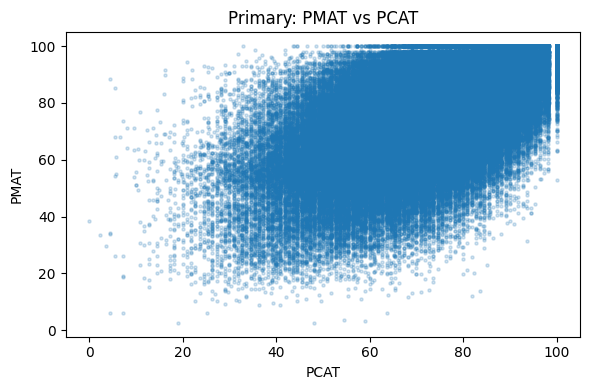

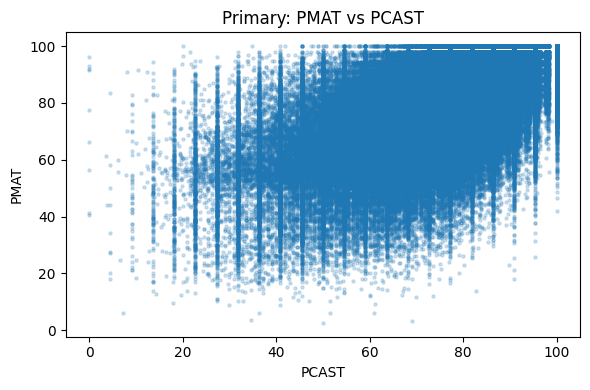

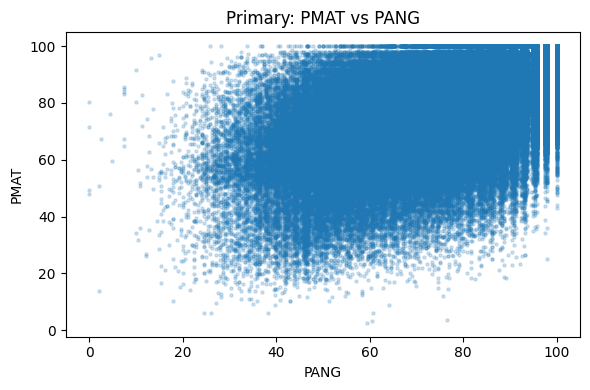

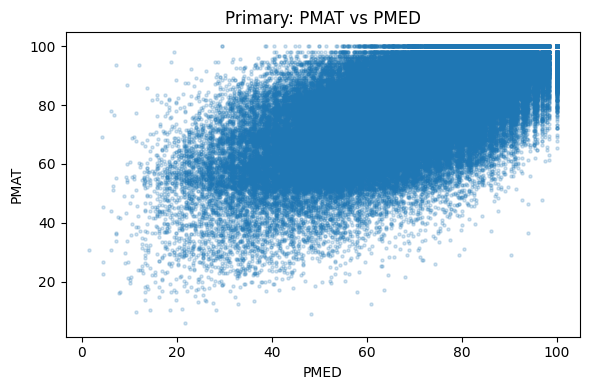

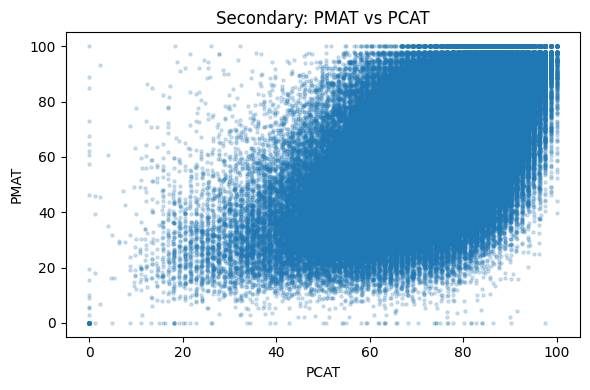

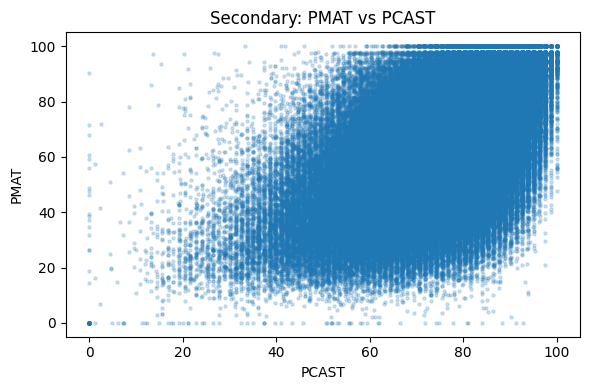

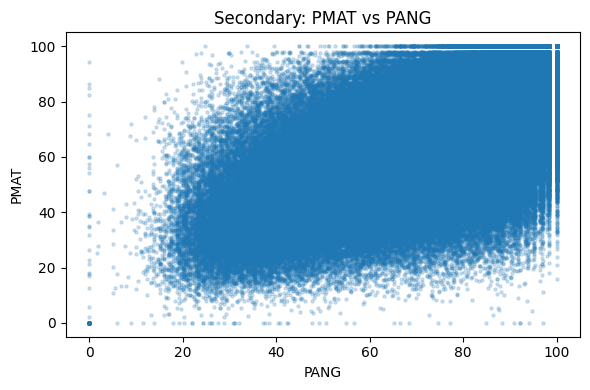

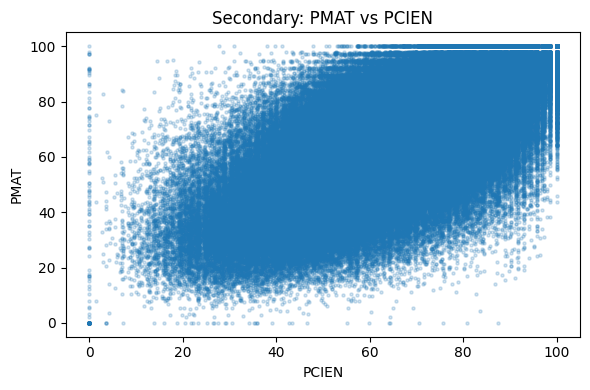

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

# ===============================
# 1. Helper: convert grade columns to numeric (comma → dot)
# ===============================
def convert_grade_columns_to_numeric(df, prefix="P"):
    """
    Convert all columns starting with a given prefix (e.g. 'P')
    from strings with comma decimals to numeric floats.
    Non-convertible values become NaN.
    """
    grade_cols = [c for c in df.columns if c.startswith(prefix)]
    for col in grade_cols:
        # Ensure string type first
        s = df[col].astype(str)
        # Replace comma with dot for decimal conversion
        s = s.str.replace(",", ".", regex=False)
        # Convert to numeric; invalid parsing becomes NaN
        df[col] = pd.to_numeric(s, errors="coerce")
    return grade_cols  # return list of converted grade columns

# ===============================
# 2. Convert grade columns in Primary (P) and Secondary (S)
# ===============================
grade_cols_P = convert_grade_columns_to_numeric(df_P_unique, prefix="P")
grade_cols_S = convert_grade_columns_to_numeric(df_S_unique, prefix="P")

grade_cols_P = ['PCAT', 'PCAST', 'PMAT', 'PANG', 'PMED']
grade_cols_S = ['PCAT', 'PCAST', 'PMAT', 'PANG', 'PCIEN']

# Choose the Mathematics column name (assumes 'PMAT' exists in both)
math_col_name = "PMAT"

# Columns for correlation (all grades except Mathematics)
other_P = [c for c in grade_cols_P if c != math_col_name]
other_S = [c for c in grade_cols_S if c != math_col_name]

# ===============================
# 3. Correlations within Primary (df_P_unique)
# ===============================
corr_P = (
    df_P_unique[other_P + [math_col_name]]
    .corr(numeric_only=True)[math_col_name]
    .sort_values(ascending=False)
)

print("=== Correlations within Primary (df_P_unique) ===")
print(f"Target: {math_col_name}")
print(corr_P)

# ===============================
# 4. Correlations within Secondary (df_S_unique)
# ===============================
corr_S = (
    df_S_unique[other_S + [math_col_name]]
    .corr(numeric_only=True)[math_col_name]
    .sort_values(ascending=False)
)

print("\n=== Correlations within Secondary (df_S_unique) ===")
print(f"Target: {math_col_name}")
print(corr_S)

# ===============================
# 5. Scatter plots: Mathematics vs other subjects (Primary and Secondary)
# ===============================
# To avoid huge plots, sample at most N students
max_points = 1000000

# Primary
if len(df_P_unique) > max_points:
    df_P_plot = df_P_unique.sample(n=max_points, random_state=0)
else:
    df_P_plot = df_P_unique

for col in other_P:
    plt.figure(figsize=(6, 4))
    plt.scatter(df_P_plot[col], df_P_plot[math_col_name], alpha=0.2, s=5)
    plt.xlabel(col)
    plt.ylabel(math_col_name)
    plt.title(f"Primary: {math_col_name} vs {col}")
    plt.tight_layout()
    path = f"Scatterplots/{col}.png"
    os.makedirs(os.path.dirname(path), exist_ok=True)
    #plt.savefig(path, dpi=300)
    plt.show()

# # Secondary
if len(df_S_unique) > max_points:
    df_S_plot = df_S_unique.sample(n=max_points, random_state=0)
else:
    df_S_plot = df_S_unique

for col in other_S:
    plt.figure(figsize=(6, 4))
    plt.scatter(df_S_plot[col], df_S_plot[math_col_name], alpha=0.2, s=5)
    plt.xlabel(col)
    plt.ylabel(math_col_name)
    plt.title(f"Secondary: {math_col_name} vs {col}")
    plt.tight_layout()
    plt.show()

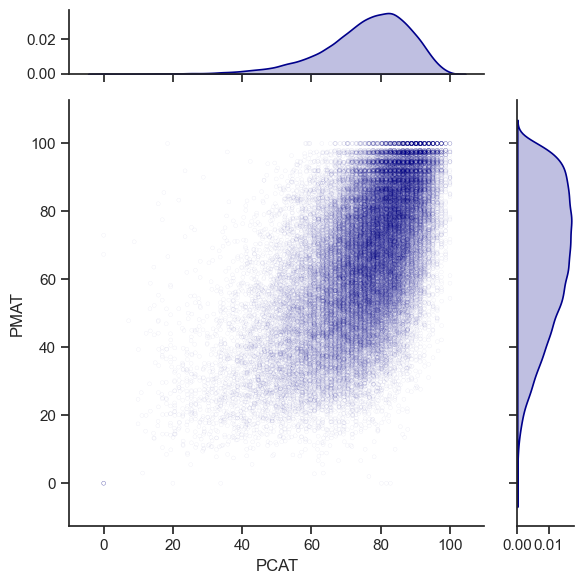

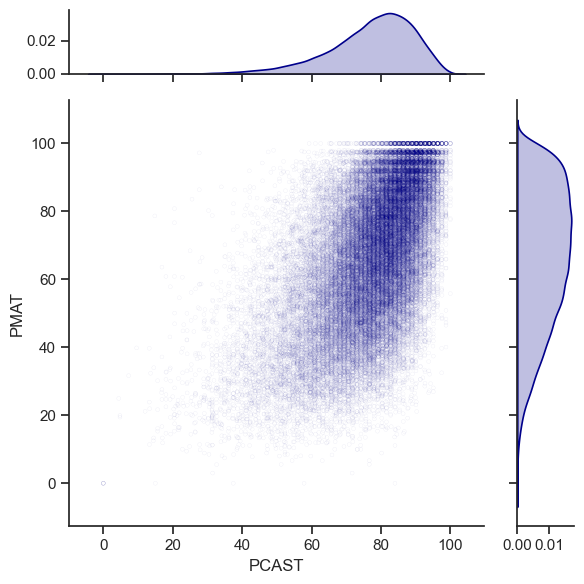

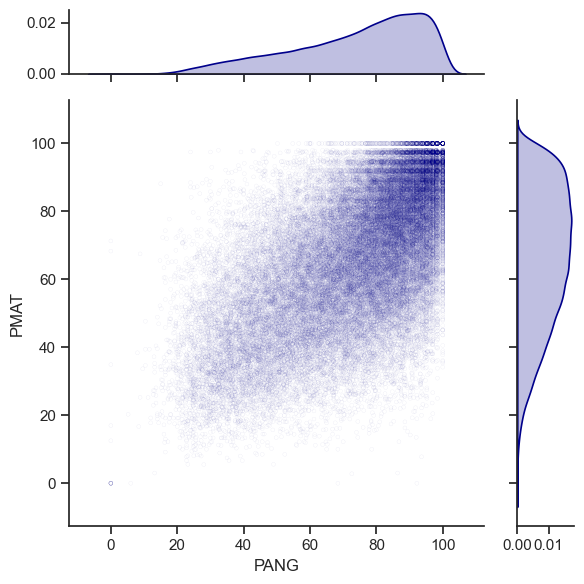

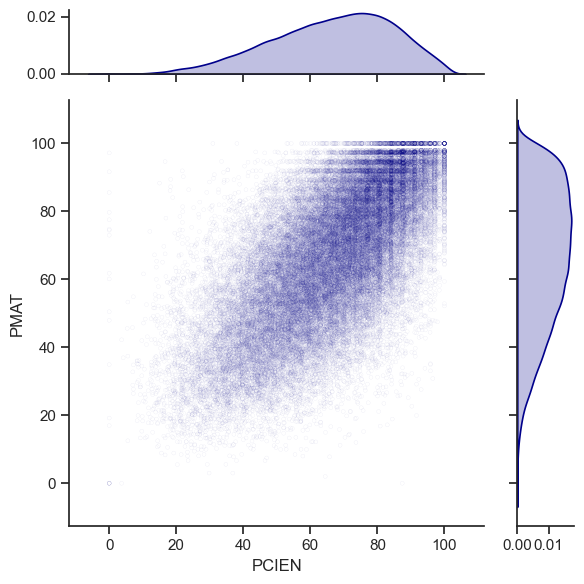

In [15]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------- Secondary ----------------------------
import numpy as np

sns.set_theme(style="ticks")

max_points = 50000

# Sample to avoid plotting an enormous dataset
if len(df_S_unique) > max_points:
    df_S_plot = df_S_unique.sample(n=max_points, random_state=0)
else:
    df_S_plot = df_S_unique

# Loop over all subjects except target
for col in other_S:
    # Skip columns that are completely NaN or identical to math column
    if col == math_col_name:
        continue
    if df_S_plot[col].dropna().empty:
        continue

    x = df_S_plot[col].values
    y = df_S_plot[math_col_name].values

    # 1. Convert everything properly
    x = df_S_plot[col].astype(str).str.replace(",", ".", regex=False)
    y = df_S_plot[math_col_name].astype(str).str.replace(",", ".", regex=False)

    # Convert to numeric
    x = pd.to_numeric(x, errors="coerce").to_numpy()
    y = pd.to_numeric(y, errors="coerce").to_numpy()

    # 2. Remove all bad values
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]
    df_S_clean = df_S_plot.iloc[mask].copy()
    df_S_clean[col] = x
    df_S_clean[math_col_name] = y

    # Initialize a JointGrid for this subject vs Mathematics
    g = sns.JointGrid(
        data=df_S_clean,
        x=col,
        y=math_col_name,
        marginal_ticks=True
    )

    # JOINT: SCATTER 
    g.plot_joint(
        sns.scatterplot,
        s=8,
        alpha=0.10,
        facecolor="none",
        edgecolor="darkblue",
        linewidth=0.2   # or whatever width you want
    )

    # Marginal smooth KDE curves on top and right
    g.plot_marginals(
        sns.kdeplot,
        fill=True,
        color="darkblue",
        linewidth=1.2
    )

    # calculate regression line
    order = np.argsort(x)
    x_sorted = x[order]
    y_sorted = y[order]

    n = len(x_sorted)
    idx_fit = 2 * n // 3
    x_fit = x_sorted[idx_fit:]
    y_fit = y_sorted[idx_fit:]

    a, b = np.polyfit(x_fit, y_fit, 1)

    xs = np.linspace(x.min(), x.max(), 300)
    ys = a * xs + b 

    #g.ax_joint.plot(xs, ys, color="brown", linestyle="--", linewidth=2)

    # Labels and title
    g.ax_joint.set_xlabel(col)
    g.ax_joint.set_ylabel(math_col_name)

    # Slight layout tweak
    plt.tight_layout()

    # Save figure to file
    out_dir = "JointPlots_Secondary"
    os.makedirs(out_dir, exist_ok=True)
    path = os.path.join(out_dir, f"Secondary_{math_col_name}_vs_{col}.png")
    g.figure.savefig(path, dpi=400, bbox_inches="tight")

    plt.show()


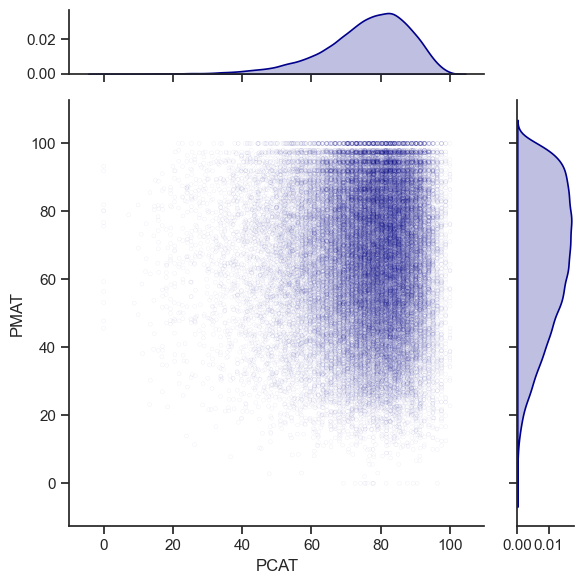

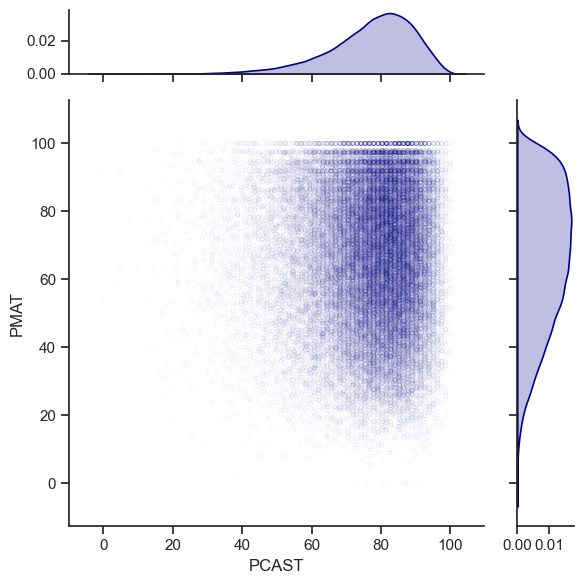

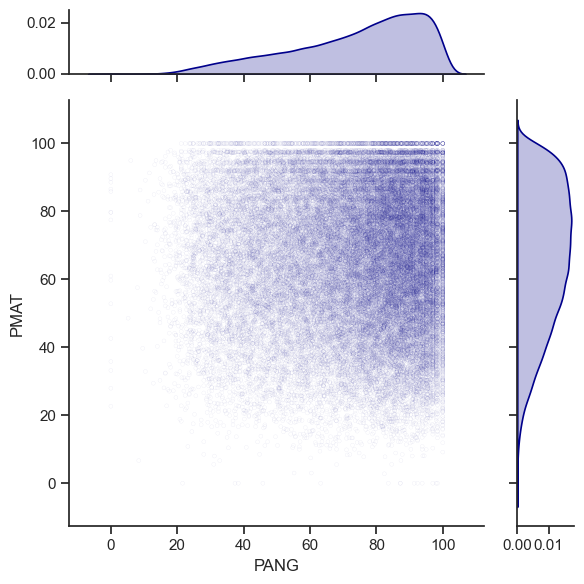

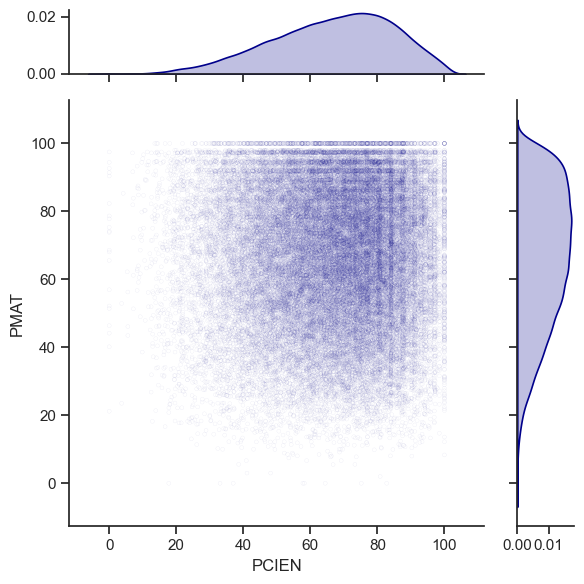

In [16]:

# ------------------- Shuffled Secondary ----------------------------
sns.set_theme(style="ticks")

#max_points = 10000

# Sample to avoid plotting an enormous dataset
if len(df_S_unique) > max_points:
    df_S_plot = df_S_unique.sample(n=max_points, random_state=0)
else:
    df_S_plot = df_S_unique

# Loop over all subjects except target
for col in other_S:
    # Skip columns that are completely NaN or identical to math column
    if col == math_col_name:
        continue
    if df_S_plot[col].dropna().empty:
        continue

    x = df_S_plot[col].values
    y = df_S_plot[math_col_name].values

    # 1. Convert everything properly
    x = df_S_plot[col].astype(str).str.replace(",", ".", regex=False)
    y = df_S_plot[math_col_name].astype(str).str.replace(",", ".", regex=False)

    # Convert to numeric
    x = pd.to_numeric(x, errors="coerce").to_numpy()
    y = pd.to_numeric(y, errors="coerce").to_numpy()

    # 2. Remove all bad values
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]
    df_S_clean = df_S_plot.iloc[mask].copy()
    df_S_clean[col] = x
    df_S_clean[math_col_name] = y

    # Suffle all values
    x_shuffled = np.random.permutation(x)
    y_shuffled = np.random.permutation(y)

    # Shuffled data
    df_S_shuffled = df_S_clean.copy()
    df_S_shuffled[col] = x_shuffled
    df_S_shuffled[math_col_name] = y_shuffled

    # Initialize a JointGrid for this subject vs Mathematics
    g = sns.JointGrid(
        data=df_S_shuffled,
        x=col,
        y=math_col_name,
        marginal_ticks=True
    )

    # JOINT: SCATTER 
    g.plot_joint(
        sns.scatterplot,
        s=8,
        alpha=0.10,
        facecolor="none",
        edgecolor="darkblue",
        linewidth=0.2   # or whatever width you want
    )

    # Marginal smooth KDE curves on top and right
    g.plot_marginals(
        sns.kdeplot,
        fill=True,
        color="darkblue",
        linewidth=1.2
    )

    # Labels and title
    g.ax_joint.set_xlabel(col)
    g.ax_joint.set_ylabel(math_col_name)

    # Slight layout tweak
    plt.tight_layout()

    # Save figure to file
    out_dir = "JointPlots_Secondary"
    os.makedirs(out_dir, exist_ok=True)
    path = os.path.join(out_dir, f"Secondary_{math_col_name}_vs_{col}.png")
    #g.figure.savefig(path, dpi=400, bbox_inches="tight")

    plt.show()


Real Data Covariance: 150.42518835545388
Shuffled Data Covariance: -2.388614936171896


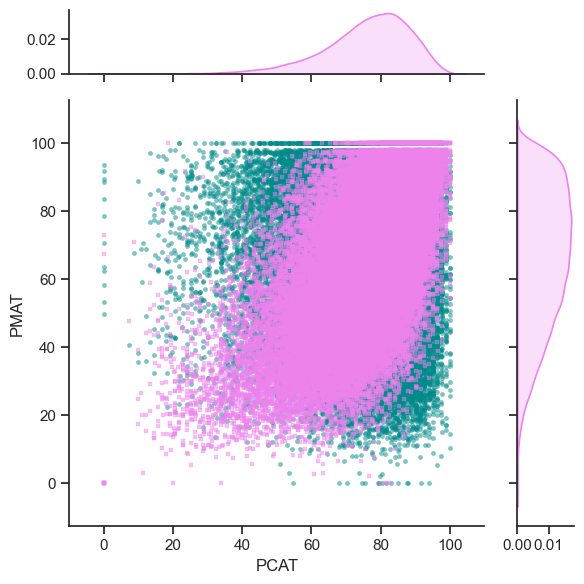

Real Data Covariance: 139.72246274360626
Shuffled Data Covariance: -1.8519301966813002


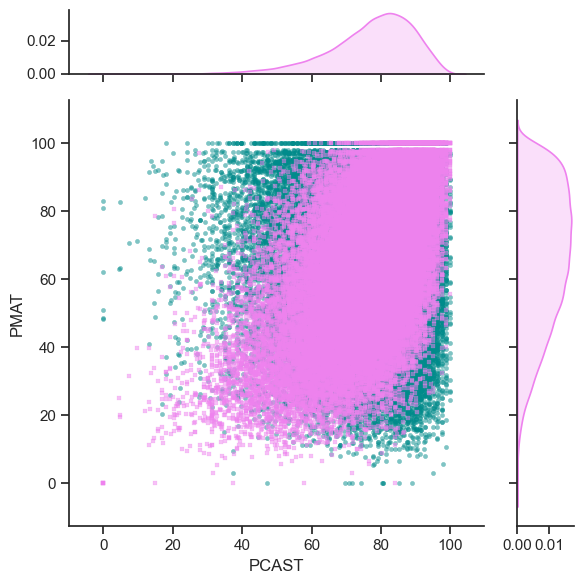

Real Data Covariance: 237.3416238422526
Shuffled Data Covariance: -0.14118930595334542


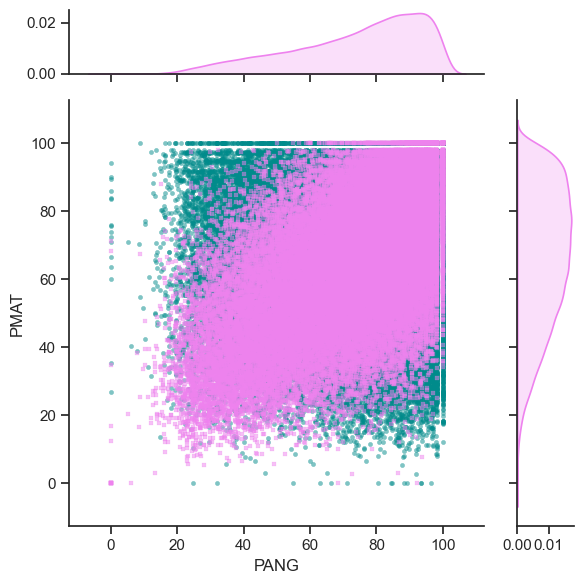

Real Data Covariance: 241.0315782962015
Shuffled Data Covariance: 2.5795533983184713


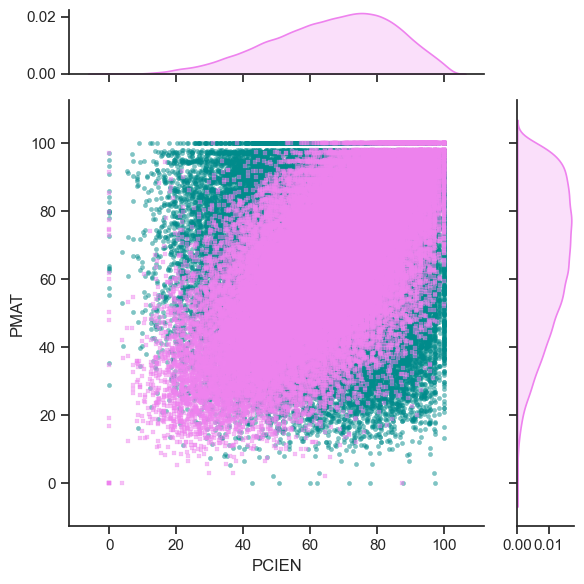

In [17]:
# ---------------- Secondary Original & Shuffled together ----------------------------------
sns.set_theme(style="ticks")

#max_points = 10000

# Sample to avoid plotting an enormous dataset
if len(df_S_unique) > max_points:
    df_S_plot = df_S_unique.sample(n=max_points, random_state=0)
else:
    df_S_plot = df_S_unique

# Loop over all subjects except target
for col in other_S:
    # Skip columns that are completely NaN or identical to math column
    if col == math_col_name:
        continue
    if df_S_plot[col].dropna().empty:
        continue

    x = df_S_plot[col].values
    y = df_S_plot[math_col_name].values

    # 1. Convert everything properly
    x = df_S_plot[col].astype(str).str.replace(",", ".", regex=False)
    y = df_S_plot[math_col_name].astype(str).str.replace(",", ".", regex=False)

    # Convert to numeric
    x = pd.to_numeric(x, errors="coerce").to_numpy()
    y = pd.to_numeric(y, errors="coerce").to_numpy()

    # 2. Remove all bad values
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]
    df_S_clean = df_S_plot.iloc[mask].copy()
    df_S_clean[col] = x
    df_S_clean[math_col_name] = y

    # Suffle all values
    x_shuffled = np.random.permutation(x)
    y_shuffled = np.random.permutation(y)

    # Shuffled data
    df_S_shuffled = df_S_clean.copy()
    df_S_shuffled[col] = x_shuffled
    df_S_shuffled[math_col_name] = y_shuffled

    # Computing covariances
    print('Real Data Covariance:',
        np.sum((x - x.mean()) * (y - y.mean())) / (len(x) - 1)
    )

    print('Shuffled Data Covariance:',
        np.sum((x_shuffled - x_shuffled.mean()) * (y_shuffled - y_shuffled.mean())) / (len(x_shuffled) - 1)
    )

    # Initialize a JointGrid for this subject vs Mathematics
    g = sns.JointGrid(
        data=df_S_shuffled,
        x=col,
        y=math_col_name,
        marginal_ticks=True
    )

    # JOINT: SCATTER 
    g.plot_joint(
        sns.scatterplot,
        s=10,
        alpha=0.5,
        facecolor="darkcyan",
        edgecolor="darkcyan",
        linewidth=0.2,
        zorder=1            # Under
    )

    g.ax_joint.scatter(
    x, y,
    s=10,
    alpha=0.50,
    facecolor="violet",
    edgecolor="violet",
    marker = 's',
    linewidth=0.2,
    zorder=2      # on top
)

    # Marginal smooth KDE curves on top and right
    g.plot_marginals(
        sns.kdeplot,
        fill=True,
        color="violet",
        linewidth=1.2
    )

    # Labels and title
    g.ax_joint.set_xlabel(col)
    g.ax_joint.set_ylabel(math_col_name)

    # Legend
#     g.ax_joint.legend(
#     loc="upper left"
# )

    # Slight layout tweak
    plt.tight_layout()

    # Save figure to file
    out_dir = "Secondary_Randomized"
    os.makedirs(out_dir, exist_ok=True)
    path = os.path.join(out_dir, f"Secondary_{math_col_name}_vs_{col}.png")
    #g.figure.savefig(path, dpi=400, bbox_inches="tight")

    plt.show()


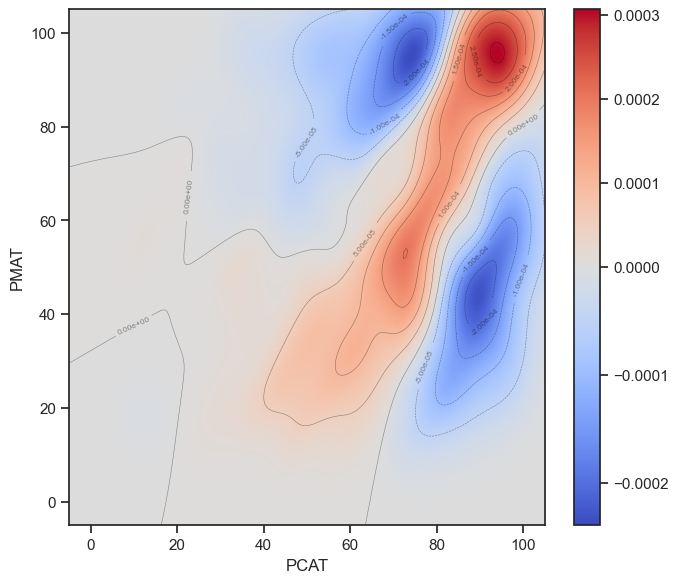

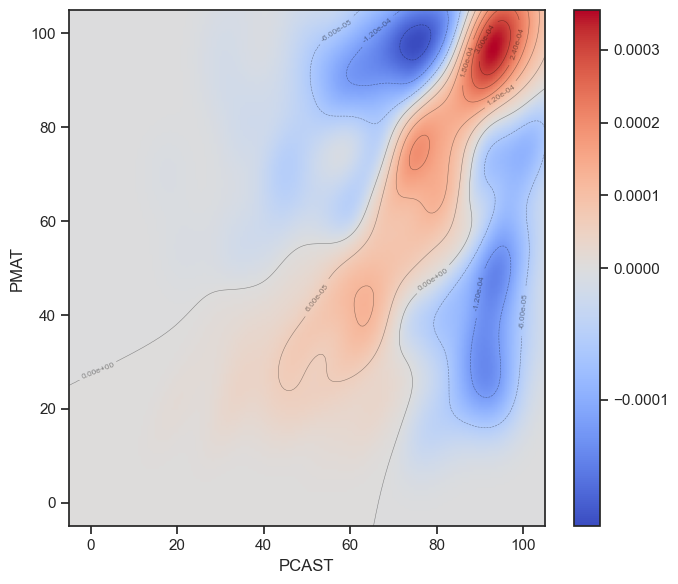

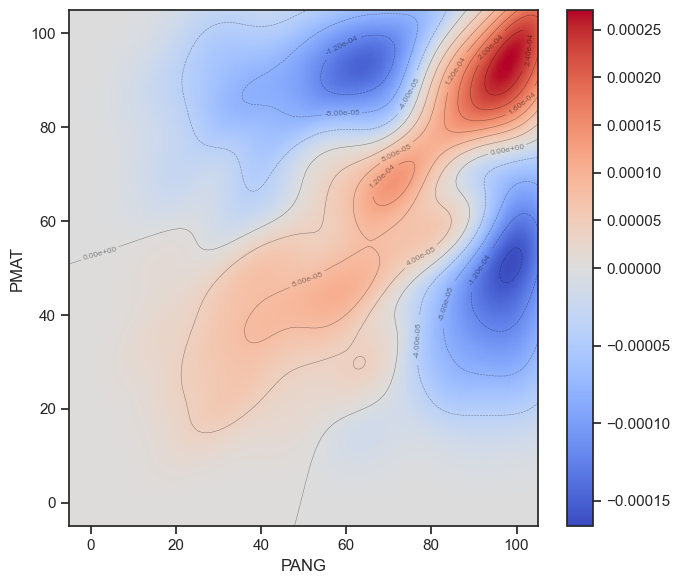

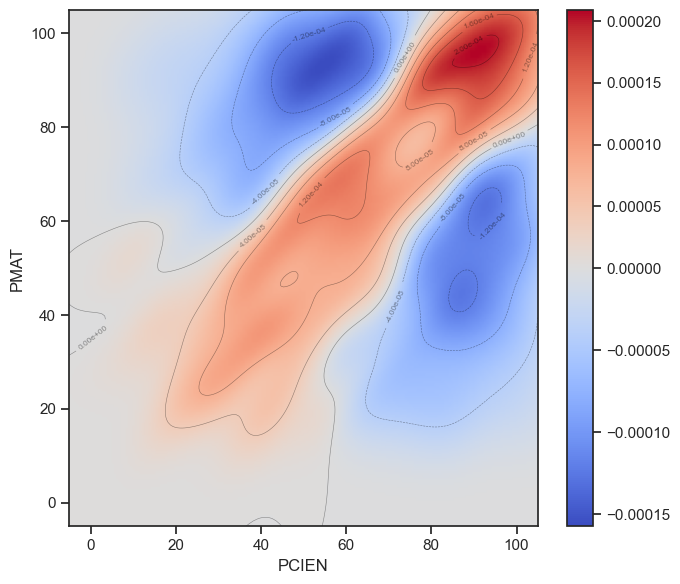

In [18]:
# -------------------- Scatter plots comparision, density difference -------------------

from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from scipy.stats import gaussian_kde
import numpy as np
import os

# ---------------- Secondary Original & Shuffled together ----------------------------------
sns.set_theme(style="ticks")

max_points = 1000

# Sample to avoid plotting an enormous dataset
if len(df_S_unique) > max_points:
    df_S_plot = df_S_unique.sample(n=max_points, random_state=0)
else:
    df_S_plot = df_S_unique

# Loop over all subjects except target
for col in other_S:
    # Skip columns that are completely NaN or identical to math column
    if col == math_col_name:
        continue
    if df_S_plot[col].dropna().empty:
        continue

    x = df_S_plot[col].values
    y = df_S_plot[math_col_name].values

    # 1. Convert everything properly
    x = df_S_plot[col].astype(str).str.replace(",", ".", regex=False)
    y = df_S_plot[math_col_name].astype(str).str.replace(",", ".", regex=False)

    # Convert to numeric
    x = pd.to_numeric(x, errors="coerce").to_numpy()
    y = pd.to_numeric(y, errors="coerce").to_numpy()

    # 2. Remove all bad values
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]
    df_S_clean = df_S_plot.iloc[mask].copy()
    df_S_clean[col] = x
    df_S_clean[math_col_name] = y

    # Suffle all values
    x_shuffled = np.random.permutation(x)
    y_shuffled = np.random.permutation(y)

    # Shuffled data
    df_S_shuffled = df_S_clean.copy()
    df_S_shuffled[col] = x_shuffled
    df_S_shuffled[math_col_name] = y_shuffled

    kde_real = gaussian_kde(np.vstack([x, y]))
    kde_shuffle = gaussian_kde(np.vstack([x_shuffled, y_shuffled]))

    # grid
    X, Y = np.mgrid[0:100:200j, 0:100:200j]
    positions = np.vstack([X.ravel(), Y.ravel()])

    Z_real = kde_real(positions).reshape(X.shape)
    Z_shuf = kde_shuffle(positions).reshape(X.shape)
    Z_diff = Z_real - Z_shuf

    # Create output directory
    os.makedirs("DensityDifferenceHeatmaps", exist_ok=True)

    # KDE grid resolution
    grid_N = 200  

    # Create grid EXTENDED slightly to reduce edge artifacts
    xmin, xmax = 0, 100
    ymin, ymax = 0, 100
    padding = 5                    # extend 5 points beyond boundaries
    X, Y = np.mgrid[
        (xmin-padding):(xmax+padding):complex(grid_N),
        (ymin-padding):(ymax+padding):complex(grid_N)
    ]
    positions = np.vstack([X.ravel(), Y.ravel()])

    # Normalization centered at 0
    norm = TwoSlopeNorm(vcenter=0, vmin=Z_diff.min(), vmax=Z_diff.max())

    # --- PLOT ---
    plt.figure(figsize=(7, 6), dpi=100)

    plt.imshow(
        Z_diff.T,   # transpose for correct orientation
        origin='lower',
        extent=[xmin-padding, xmax+padding, ymin-padding, ymax+padding],
        cmap='coolwarm',
        norm=norm,
        aspect='auto'
    )

    # Contour lines
    ct = plt.contour(
        X, Y, Z_diff,
        levels=10,
        colors='black',
        linewidths=0.4,
        alpha=0.4
    )
    plt.clabel(ct, inline=True, fontsize=6, fmt="%.2e")

    im = plt.imshow(
    Z_diff.T,
    origin='lower',
    cmap='coolwarm',
    norm=norm,
    extent=[xmin-padding, xmax+padding, ymin-padding, ymax+padding],
    aspect='auto'
)
    plt.colorbar(im)

    plt.xlabel(col)
    plt.ylabel(math_col_name)

    #plt.title(f"Density Difference Heatmap: {col} vs {math_col_name}")

    plt.tight_layout()

    # Save figure
    filepath = f"DensityDifferenceHeatmaps/{col}_heatmap.png"
    plt.savefig(filepath, dpi=100)
    plt.show()

C:\Users\maria\AppData\Local\Temp\ipykernel_2328\858588512.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


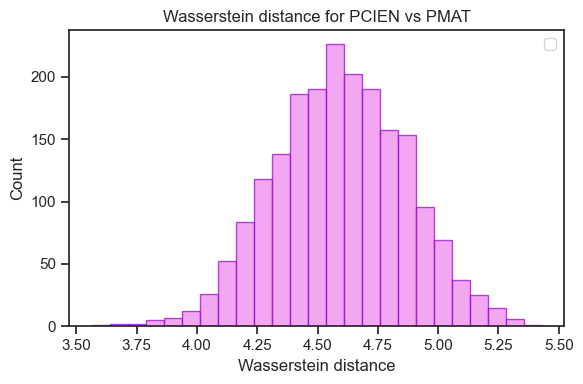

In [ ]:
from scipy.stats import wasserstein_distance
import numpy as np
import matplotlib.pyplot as plt

def project_45(x, y):
    # simple projection onto line y = x
    return (x + y) / np.sqrt(2)

def wasser(x, y, n_perm = 1000):

    # 1. Convert everything properly
    x = df_S_plot[col].astype(str).str.replace(",", ".", regex=False)
    y = df_S_plot[math_col_name].astype(str).str.replace(",", ".", regex=False)

    # Convert to numeric
    x = pd.to_numeric(x, errors="coerce").to_numpy()
    y = pd.to_numeric(y, errors="coerce").to_numpy()

    # 2. Remove all bad values
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]
    df_S_clean = df_S_plot.iloc[mask].copy()
    df_S_clean[col] = x
    df_S_clean[math_col_name] = y

    # 1) observed distance
    z_real = project_45(x, y)

    # 2) null distribution via extra shuffles
    W_null = []

    for _ in range(n_perm):
        y_perm = np.random.permutation(y)      # break dependence
        z_perm = project_45(x, y_perm)
        W_null.append(wasserstein_distance(z_real, z_perm))

    W_null = np.array(W_null)

    return W_null

x = df_S_plot['PCAT'].values
y = df_S_plot['PMAT'].values

W_null = wasser(x, y, n_perm = 2000)

# 3) plot
plt.figure(figsize=(6,4))
plt.hist(W_null, bins=25, alpha=0.7, color="violet", edgecolor="darkviolet")
plt.xlabel("Wasserstein distance")
plt.ylabel("Count")
plt.title(f"Wasserstein distance for {col} vs {math_col_name}")
plt.legend()
plt.tight_layout()
plt.show()

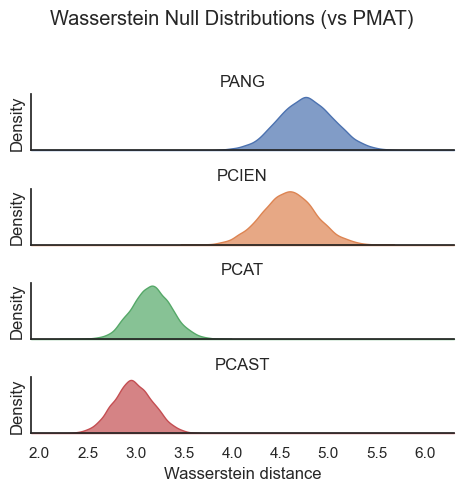

In [ ]:
# --- collect Wasserstein null distributions ---
W_dists = {}    # subject → list of W values

for col in other_S:
    if col == math_col_name:
        continue
    
    # Call YOUR function
    Ws = wasser(df_S_plot[col], df_S_plot[math_col_name], n_perm=10000)
    
    if len(Ws) > 0:
        W_dists[col] = Ws

# --- Convert to long dataframe for plotting ---
rows = []
for subj, Ws in W_dists.items():
    for w in Ws:
        rows.append({"subject": subj, "W": w})

W_long = pd.DataFrame(rows)

# Sort subjects by mean W (strongest dependence first)
mean_scores = W_long.groupby("subject")["W"].mean().sort_values(ascending=False)
ordered_subjects = mean_scores.index.tolist()

W_long["subject"] = pd.Categorical(W_long["subject"], 
                                   categories=ordered_subjects, 
                                   ordered=True)


# --- Ridgeline plot ---
sns.set_theme(style="white")

g = sns.FacetGrid(
    W_long,
    row="subject",
    hue="subject",
    aspect=4,
    height=1.2,
    sharex=True,
    sharey=False
)

g.map(sns.kdeplot, "W", fill=True, alpha=0.7)
g.map(plt.axhline, y=0, lw=1, clip_on=False)

g.set_titles(row_template="{row_name}")
g.set_xlabels("Wasserstein distance")
g.set_ylabels("Density")

# Make ridgeline cleaner
for ax in g.axes.flatten():
    ax.set_yticks([])

plt.suptitle(f"Wasserstein Null Distributions (vs {math_col_name})", y=1.02)
plt.tight_layout()
plt.show()

In [71]:
from scipy.stats import wasserstein_distance
import numpy as np
import pandas as pd

def project_45(x, y):
    return (x + y) / np.sqrt(2)

def wasser(x_raw, y_raw, n_perm=500):
    # 1. Clean conversion
    x = x_raw.astype(str).str.replace(",", ".", regex=False)
    y = y_raw.astype(str).str.replace(",", ".", regex=False)

    x = pd.to_numeric(x, errors="coerce").to_numpy()
    y = pd.to_numeric(y, errors="coerce").to_numpy()

    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]

    # Observed statistic = mean W between real (x,y) and many shuffled y
    z_real = project_45(x, y)

    W_obs_list = []
    for _ in range(n_perm):
        y_perm = np.random.permutation(y)
        z_perm = project_45(x, y_perm)
        W_obs_list.append(wasserstein_distance(z_real, z_perm))

    W_obs = np.mean(W_obs_list)

    # Null distribution: distances under full independence
    W_null = []
    for _ in range(n_perm):
        y_perm1 = np.random.permutation(y)
        y_perm2 = np.random.permutation(y)

        z1 = project_45(x, y_perm1)
        z2 = project_45(x, y_perm2)

        W_null.append(wasserstein_distance(z1, z2))

    return W_obs, np.array(W_null)

p_values = {}
W_observed_values = {}

for col in other_S:
    if col == math_col_name:
        continue

    W_obs, W_null = wasser(df_S_plot[col], df_S_plot[math_col_name], n_perm=2000)
    print(np.mean(W_null))

    # p-value formula:
    p = np.mean(W_null >= W_obs)

    p_values[col] = p
    W_observed_values[col] = W_obs

results_df = pd.DataFrame({
    "W_obs": W_observed_values,
    "p_value": p_values
}).sort_values("W_obs", ascending=False)

print(results_df)

0.5809397250696203
0.5856358757948973
0.7208432827066065
0.7109306493995017
          W_obs  p_value
PANG   4.768456      0.0
PCIEN  4.584930      0.0
PCAT   3.169734      0.0
PCAST  2.973656      0.0


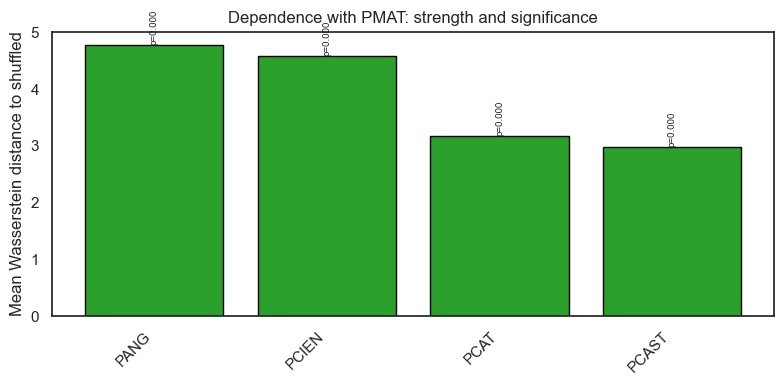

In [72]:
import matplotlib.pyplot as plt

subjects = results_df.index
W_vals   = results_df["W_obs"].values
p_vals   = results_df["p_value"].values

# Color: verd si p < 0.05, gris si no
colors = ["tab:green" if p < 0.05 else "lightgray" for p in p_vals]

plt.figure(figsize=(8, 4))
plt.bar(subjects, W_vals, color=colors, edgecolor="black")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean Wasserstein distance to shuffled")
plt.title(f"Dependence with {math_col_name}: strength and significance")

# línia horitzontal opcional: el valor mitjà de W_null d'alguna assignatura,
# o el percentil, si vols una referència visual extra.

# També pots escriure el p damunt de les barres:
for x_pos, (w, p) in enumerate(zip(W_vals, p_vals)):
    plt.text(x_pos, w, f"p={p:.3f}", ha="center", va="bottom", fontsize=7, rotation=90)

plt.tight_layout()
plt.show()


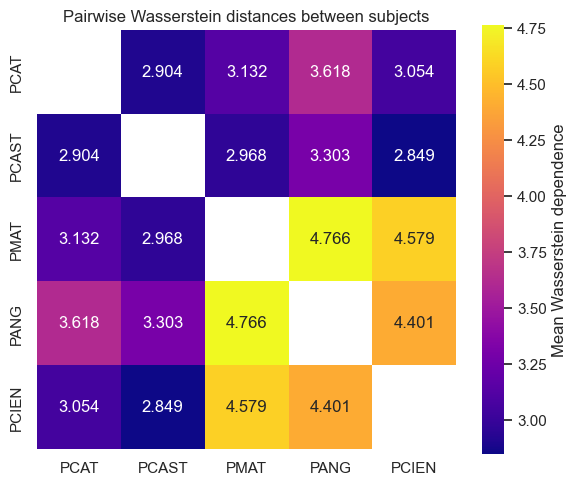

In [80]:
grade_cols_S = ['PCAT', 'PCAST', 'PMAT', 'PANG', 'PCIEN']

from scipy.stats import wasserstein_distance
import numpy as np
import pandas as pd

def project_45(x, y):
    """Project (x, y) onto the line y = x."""
    return (x + y) / np.sqrt(2)

def wasser_correct(x_raw, y_raw, n_perm=200):
    """
    Compute observed Wasserstein dependence between two subjects:
    - Clean numeric data
    - Project onto 45º
    - W_obs = mean distance between real projection and many shuffled copies
    (W_null aquí no el farem servir per la matriu, només retornem W_obs)
    """
    # Convert to numeric with dot decimals
    x = x_raw.astype(str).str.replace(",", ".", regex=False)
    y = y_raw.astype(str).str.replace(",", ".", regex=False)

    x = pd.to_numeric(x, errors="coerce").to_numpy()
    y = pd.to_numeric(y, errors="coerce").to_numpy()

    # Remove NaNs
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]

    if len(x) < 20:
        return np.nan  # not enough data

    z_real = project_45(x, y)

    # Observed: average distance between real and many shuffled copies
    W_obs_list = []
    for _ in range(n_perm):
        y_perm = np.random.permutation(y)
        z_perm = project_45(x, y_perm)
        W_obs_list.append(wasserstein_distance(z_real, z_perm))

    W_obs = float(np.mean(W_obs_list))
    return W_obs

import seaborn as sns
import matplotlib.pyplot as plt

# Define your subject list (adapt this to your real columns)
grade_cols_S = ['PCAT', 'PCAST', 'PMAT', 'PANG', 'PCIEN']

# Initialize empty distance matrix
W_matrix = pd.DataFrame(
    np.nan,
    index=grade_cols_S,
    columns=grade_cols_S,
    dtype=float
)

# Fill upper triangle (and mirror to lower triangle)
for i, col_i in enumerate(grade_cols_S):
    for j, col_j in enumerate(grade_cols_S):
        if j < i:
            continue  # we will mirror later
        if col_i == col_j:
            W_matrix.loc[col_i, col_j] = 0.0  # distance with itself
        else:
            W_ij = wasser_correct(df_S_plot[col_i], df_S_plot[col_j], n_perm=200)
            W_matrix.loc[col_i, col_j] = W_ij
            W_matrix.loc[col_j, col_i] = W_ij  # symmetric

plt.figure(figsize=(6, 5))
sns.set_theme(style="white")

# Mask diagonal if you prefer it blank
# mask = np.zeros_like(W_matrix, dtype=bool)
# np.fill_diagonal(mask, True)

sns.heatmap(
    W_matrix,
    mask=mask,
    cmap="plasma",
    annot=True,         # posa els valors numèrics a cada cel·la
    fmt=".3f",
    square=True,
    cbar_kws={"label": "Mean Wasserstein dependence"}
)

plt.title("Pairwise Wasserstein distances between subjects")
plt.tight_layout()
plt.show()

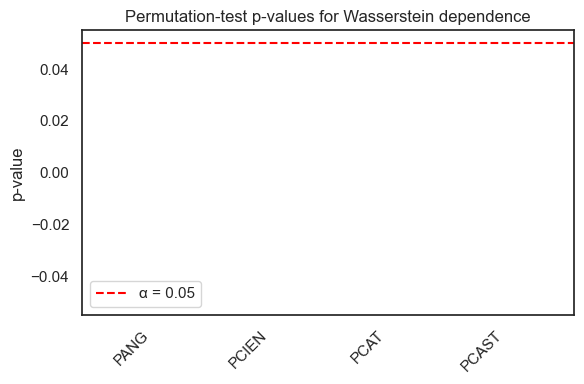

In [70]:
plt.figure(figsize=(6,4))
plt.bar(results_df.index, results_df["p_value"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("p-value")
plt.title("Permutation-test p-values for Wasserstein dependence")
plt.axhline(0.05, color="red", linestyle="--", label="α = 0.05")
plt.legend()
plt.tight_layout()
plt.show()

In [50]:
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance

def to_float_series(s):
    s = s.astype(str).str.replace(",", ".", regex=False)
    return pd.to_numeric(s, errors="coerce")

def project_45(x, y):
    return (x + y) / np.sqrt(2)

def wasserstein_null_distribution(x_raw, y_raw, K=100, random_state=None):
    """
    For one subject vs maths, return a list of Wasserstein distances
    between the real projected data and K shuffled versions.
    """
    rng = np.random.default_rng(random_state)

    x = to_float_series(x_raw).to_numpy()
    y = to_float_series(y_raw).to_numpy()
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]

    if len(x) < 20:
        return []

    z_real = project_45(x, y)

    Ws = []
    for _ in range(K):
        y_perm = rng.permutation(y)
        z_perm = project_45(x, y_perm)
        Ws.append(wasserstein_distance(z_real, z_perm))

    return Ws

# --------- compute for all subjects ---------

K = 100  # number of shuffles per subject

W_dists = {}   # subject -> list of W's
W_means = {}   # subject -> mean W

for col in other_S:
    if col == math_col_name:
        continue

    Ws = wasserstein_null_distribution(df_S_plot[col], df_S_plot[math_col_name],
                                       K=K, random_state=0)
    if len(Ws) == 0:
        continue

    W_dists[col] = Ws
    W_means[col] = float(np.mean(Ws))

W_mean_series = pd.Series(W_means).sort_values(ascending=False)


<Figure size 700x500 with 0 Axes>

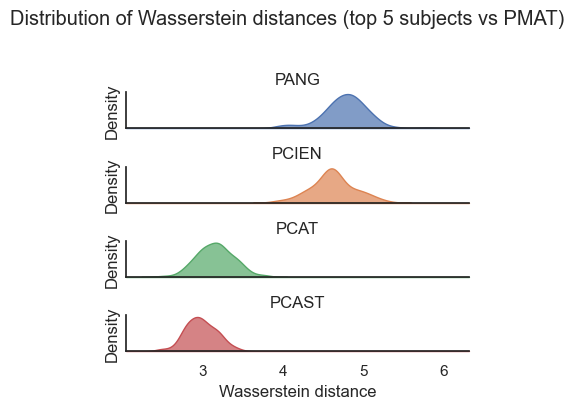

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Build long DataFrame with all W distances
rows = []
for subj, Ws in W_dists.items():
    for w in Ws:
        rows.append({"subject": subj, "W": w})

W_long = pd.DataFrame(rows)

# Focus on top N subjects by mean W
top_n = 5
top_subjects = W_mean_series.head(top_n).index.tolist()
W_long_top = W_long[W_long["subject"].isin(top_subjects)]

# Order subjects by mean W (for nice vertical ordering)
W_long_top["subject"] = pd.Categorical(
    W_long_top["subject"],
    categories=top_subjects,
    ordered=True
)

# Ridgeline-style KDEs: one row per subject
plt.figure(figsize=(7, 5))
sns.set_theme(style="white")  # cleaner background

g = sns.FacetGrid(
    W_long_top,
    row="subject",
    hue="subject",
    aspect=4,
    height=1.0,
    sharex=True,
    sharey=False
)

g.map(sns.kdeplot, "W", fill=True, alpha=0.7)
g.map(plt.axhline, y=0, lw=1, clip_on=False)

g.set_titles(row_template="{row_name}")
g.set_xlabels("Wasserstein distance")
g.set_ylabels("Density")

for ax in g.axes.flatten():
    ax.set_yticks([])  # cleaner ridgeline look

plt.suptitle(f"Distribution of Wasserstein distances (top {top_n} subjects vs {math_col_name})",
             y=1.02)
plt.tight_layout()
plt.show()


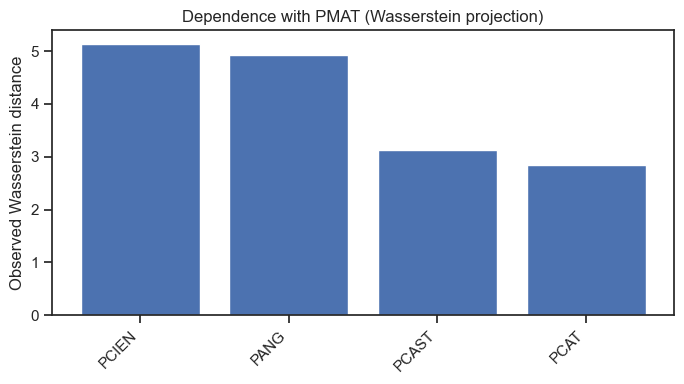

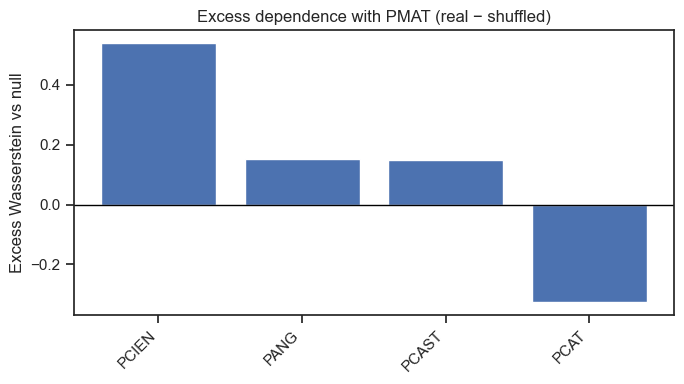

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

# ---------- helpers ----------

def to_float_series(s):
    """
    Convert a pandas Series with comma decimals / strings to float,
    coercing invalid entries to NaN.
    """
    s = s.astype(str).str.replace(",", ".", regex=False)
    return pd.to_numeric(s, errors="coerce")

def project_45(x, y):
    """Projection onto the y = x direction."""
    return (x + y) / np.sqrt(2)

def wasserstein_for_pair(x_raw, y_raw, n_perm_null=0, random_state=None):
    """
    Compute observed 1D Wasserstein distance between the 45° projections
    of (x, y) and a shuffled version (null model).
    Optionally also return mean null W if n_perm_null > 0.
    """
    rng = np.random.default_rng(random_state)

    # Clean and align
    x = to_float_series(x_raw).to_numpy()
    y = to_float_series(y_raw).to_numpy()
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]

    if len(x) < 20:
        return np.nan, np.nan  # not enough data

    # Observed
    z_real = project_45(x, y)
    y_shuf = rng.permutation(y)
    z_shuf = project_45(x, y_shuf)
    W_obs = wasserstein_distance(z_real, z_shuf)

    if n_perm_null <= 0:
        return W_obs, np.nan

    # Null distribution
    W_null = []
    for _ in range(n_perm_null):
        y_perm = rng.permutation(y)
        z_perm = project_45(x, y_perm)
        W_null.append(wasserstein_distance(z_real, z_perm))

    W_null = np.array(W_null)
    return W_obs, W_null.mean()


# ---------- compute Wasserstein for all subjects ----------

W_obs_dict = {}
W_excess_dict = {}  # W_obs - mean(W_null) → "beyond noise"

for col in other_S:
    if col == math_col_name:
        continue

    W_obs, W_null_mean = wasserstein_for_pair(
        df_S_plot[col],
        df_S_plot[math_col_name],
        n_perm_null=1000,        # number of permutations for null model
        random_state=0
    )

    if np.isnan(W_obs):
        continue

    W_obs_dict[col] = W_obs
    if not np.isnan(W_null_mean):
        W_excess_dict[col] = W_obs - W_null_mean

# Convert to Series and sort (largest dependence first)
W_obs_series = pd.Series(W_obs_dict).sort_values(ascending=False)
W_excess_series = pd.Series(W_excess_dict).sort_values(ascending=False)

# ---------- barplot: raw W_obs ----------

plt.figure(figsize=(7, 4))
plt.bar(W_obs_series.index, W_obs_series.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Observed Wasserstein distance")
plt.title(f"Dependence with {math_col_name} (Wasserstein projection)")
plt.tight_layout()
plt.show()

# ---------- barplot: W_obs – mean(null) (optional, nicer statistically) ----------

plt.figure(figsize=(7, 4))
plt.bar(W_excess_series.index, W_excess_series.values)
plt.xticks(rotation=45, ha="right")
plt.axhline(0, color="black", linewidth=1)
plt.ylabel("Excess Wasserstein vs null")
plt.title(f"Excess dependence with {math_col_name} (real − shuffled)")
plt.tight_layout()
plt.show()

In [ ]:
# ---------------- COVARIANCES ----------------------------------
sns.set_theme(style="ticks")

#max_points = 10000

# Sample to avoid plotting an enormous dataset
if len(df_S_unique) > max_points:
    df_S_plot = df_S_unique.sample(n=max_points, random_state=0)
else:
    df_S_plot = df_S_unique

# Initializing covariances
RealCov = []
ShuffledCov = []

# Loop over all subjects except target
for col in other_S:
    # Skip columns that are completely NaN or identical to math column
    if col == math_col_name:
        continue
    if df_S_plot[col].dropna().empty:
        continue

    x = df_S_plot[col].values
    y = df_S_plot[math_col_name].values

    # 1. Convert everything properly
    x = df_S_plot[col].astype(str).str.replace(",", ".", regex=False)
    y = df_S_plot[math_col_name].astype(str).str.replace(",", ".", regex=False)

    # Convert to numeric
    x = pd.to_numeric(x, errors="coerce").to_numpy()
    y = pd.to_numeric(y, errors="coerce").to_numpy()

    # 2. Remove all bad values
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]
    df_S_clean = df_S_plot.iloc[mask].copy()
    df_S_clean[col] = x
    df_S_clean[math_col_name] = y

    # Computing covariances

    RealCov.append(
        np.sum((x - x.mean()) * (y - y.mean())) / (len(x) - 1)
    )

    cov = []
    for _ in range(1000):
        # Suffle all values
        x_shuffled = np.random.permutation(x)
        y_shuffled = np.random.permutation(y)
        cov.append(np.sum((x_shuffled - x_shuffled.mean()) * (y_shuffled - y_shuffled.mean())) / (len(x_shuffled) - 1))

    ShuffledCov.append(
       np.max(cov)
    )

In [ ]:
print(RealCov)
print(ShuffledCov)

[np.float64(150.42518835545388), np.float64(139.72246274360626), np.float64(237.3416238422526), np.float64(241.0315782962015)]
[np.float64(4.273732430527483), np.float64(3.963481574271159), np.float64(6.007186510999335), np.float64(5.830725531267527)]


## Covariance matrix

In [ ]:
# Convert columns to numeric (if grades still have comma decimals)
df_cov_P = df_P_unique[grade_cols_P].apply(
    lambda col: pd.to_numeric(col.astype(str).str.replace(",", ".", regex=False),
                              errors="coerce")
)

# Remove rows with all NaN (optional)
df_cov_P = df_cov_P.dropna(how="all")

# Compute covariance matrix
cov_matrix_P = df_cov_P.cov()

# Convert columns to numeric (if grades still have comma decimals)
df_cov_S = df_S_unique[grade_cols_S].apply(
    lambda col: pd.to_numeric(col.astype(str).str.replace(",", ".", regex=False),
                              errors="coerce")
)

# Remove rows with all NaN (optional)
df_cov_S = df_cov_S.dropna(how="all")

# Compute covariance matrix
cov_matrix_S = df_cov_S.cov()

print(cov_matrix_P)
print(cov_matrix_S)


0            PCAT       PCAST        PMAT        PANG        PMED
0                                                                
PCAT   192.835786  157.767519  127.212585  157.497407  147.143574
PCAST  157.767519  231.333919  135.173864  160.797089  153.949954
PMAT   127.212585  135.173864  228.927993  135.332359  153.006604
PANG   157.497407  160.797089  135.332359  267.809760  166.854161
PMED   147.143574  153.949954  153.006604  166.854161  283.311850
0            PCAT       PCAST        PMAT        PANG       PCIEN
0                                                                
PCAT   167.468386  112.799369  148.087085  163.132301  131.206103
PCAST  112.799369  160.900640  138.449139  151.036753  115.658031
PMAT   148.087085  138.449139  404.781966  235.831253  240.820183
PANG   163.132301  151.036753  235.831253  389.663828  214.203333
PCIEN  131.206103  115.658031  240.820183  214.203333  330.910903


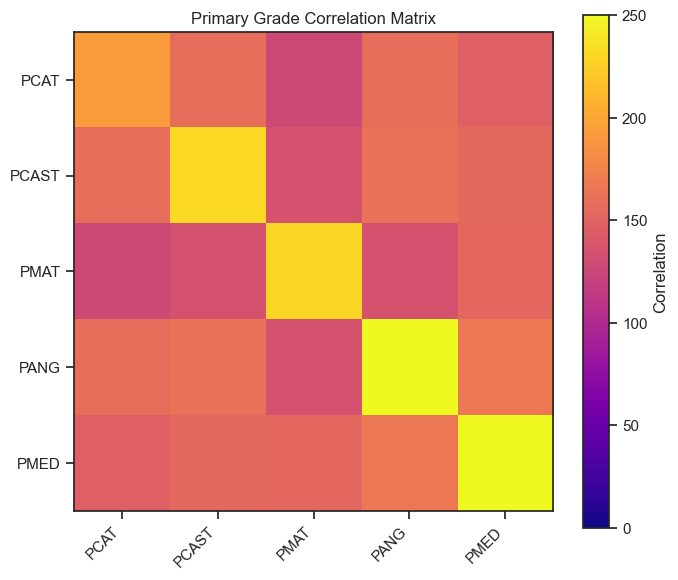

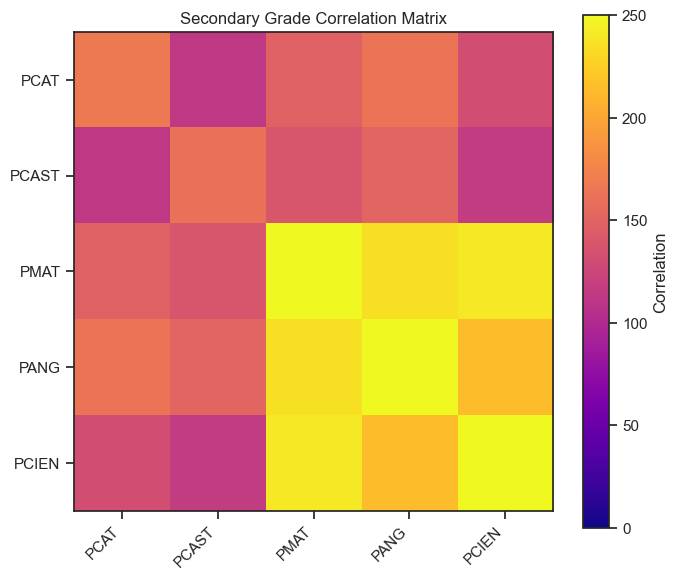

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

cmap ="plasma"

def plot_cov_matrix(matrix, labels, title, name):
    plt.figure(figsize=(7, 6))
    plt.imshow(matrix, cmap=cmap, vmin=0.0, vmax=250)
    plt.colorbar(label="Correlation")
    plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
    plt.yticks(range(len(labels)), labels)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(name, dpi=600)
    plt.show()

# Plot primary
plot_cov_matrix(
    cov_matrix_P,
    labels=cov_matrix_P.columns if hasattr(cov_matrix_P, "columns") else [f"C{i}" for i in range(6)],
    title="Primary Grade Correlation Matrix",
    name = 'primaryMatrix'
)

# Plot secondary
plot_cov_matrix(
    cov_matrix_S,
    labels=cov_matrix_S.columns if hasattr(cov_matrix_S, "columns") else [f"C{i}" for i in range(7)],
    title="Secondary Grade Correlation Matrix",
    name = 'SecondaryMatrix'
)

In [ ]:
import pandas as pd
import numpy as np

# ---------------------------------------
# 1. Helper function: convert comma → dot → float
# ---------------------------------------
def convert_grade_columns_to_numeric(df, columns):
    """
    Converts the selected grade columns from string/comma format
    into numeric float format. Non-convertible values become NaN.
    """
    for col in columns:
        s = df[col].astype(str).str.replace(",", ".", regex=False)
        df[col] = pd.to_numeric(s, errors="coerce")
    return df

# ---------------------------------------
# 2. Define the columns for each stage
# ---------------------------------------
grade_cols_P = ['PCAT', 'PCAST', 'PANG', 'PMAT', 'PMED', 'PFRAN']
grade_cols_S = ['PCAT', 'PCAST', 'PANG', 'PMAT', 'PCIEN', 'PFRAN']

# ---------------------------------------
# 3. Convert grades to numeric
# ---------------------------------------
convert_grade_columns_to_numeric(df_P_unique, grade_cols_P)
convert_grade_columns_to_numeric(df_S_unique, grade_cols_S)

# ---------------------------------------
# 4. Compute correlation matrices
# ---------------------------------------
corr_primary = df_P_unique[grade_cols_P].corr(numeric_only=True)
corr_secondary = df_S_unique[grade_cols_S].corr(numeric_only=True)

# ---------------------------------------
# 5. Print the matrices
# ---------------------------------------
print("=== Correlation Matrix: PRIMARY ===")
print(corr_primary)

print("\n=== Correlation Matrix: SECONDARY ===")
print(corr_secondary)

=== Correlation Matrix: PRIMARY ===
0          PCAT     PCAST      PANG      PMAT      PMED     PFRAN
0                                                                
PCAT   1.000000  0.750011  0.695518  0.606761  0.668415  0.654617
PCAST  0.750011  1.000000  0.648068  0.588814  0.663345  0.608240
PANG   0.695518  0.648068  1.000000  0.548953  0.581833  0.701156
PMAT   0.606761  0.588814  0.548953  1.000000  0.648560  0.522115
PMED   0.668415  0.663345  0.581833  0.648560  1.000000  0.603170
PFRAN  0.654617  0.608240  0.701156  0.522115  0.603170  1.000000

=== Correlation Matrix: SECONDARY ===
0          PCAT     PCAST      PANG      PMAT     PCIEN     PFRAN
0                                                                
PCAT   1.000000  0.695360  0.649580  0.572081  0.565905  0.636633
PCAST  0.695360  1.000000  0.611670  0.545036  0.508057  0.545719
PANG   0.649580  0.611670  1.000000  0.598948  0.599437       NaN
PMAT   0.572081  0.545036  0.598948  1.000000  0.663591  0.540417
P

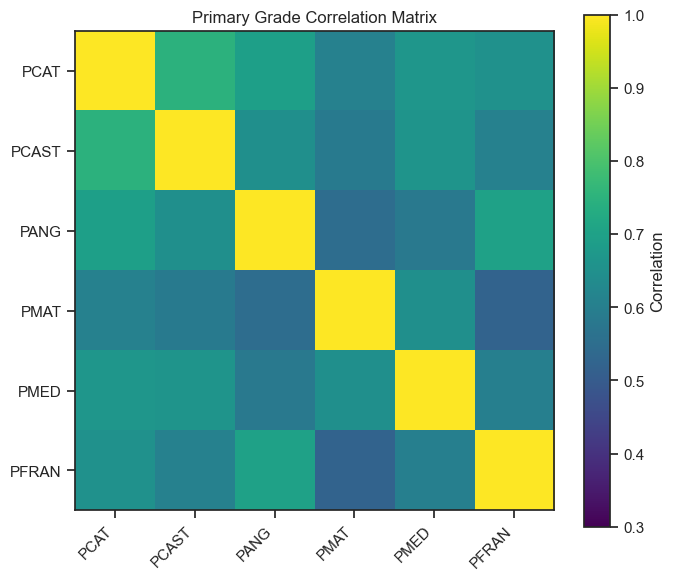

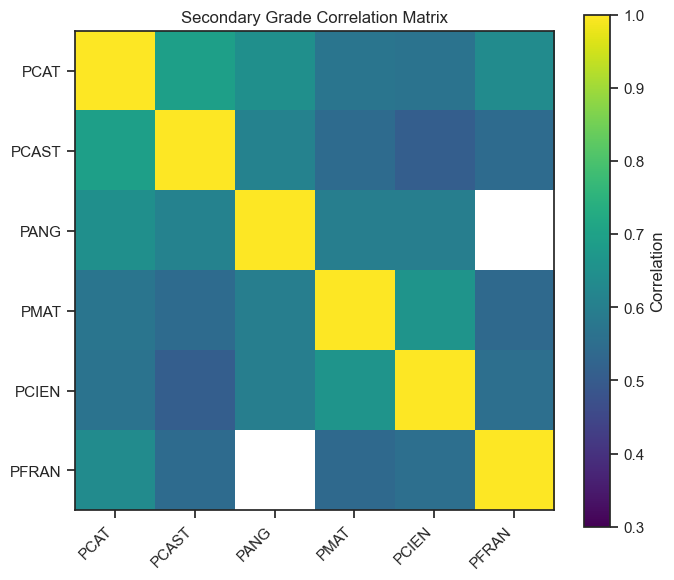

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

cmap ="viridis"

def plot_corr_matrix(matrix, labels, title, name):
    plt.figure(figsize=(7, 6))
    plt.imshow(matrix, cmap=cmap, vmin=0.3, vmax=1)
    plt.colorbar(label="Correlation")
    plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
    plt.yticks(range(len(labels)), labels)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(name, dpi=600)
    plt.show()

# Plot primary
plot_corr_matrix(
    corr_primary,
    labels=corr_primary.columns if hasattr(corr_primary, "columns") else [f"C{i}" for i in range(6)],
    title="Primary Grade Correlation Matrix",
    name = 'primaryMatrix'
)

# Plot secondary
plot_corr_matrix(
    corr_secondary,
    labels=corr_secondary.columns if hasattr(corr_secondary, "columns") else [f"C{i}" for i in range(7)],
    title="Secondary Grade Correlation Matrix",
    name = 'SecondaryMatrix'
)

In [ ]:
from scipy.stats import pearsonr

def correlation_with_significance(df, col1, col2):
    """
    Computes Pearson correlation and p-value between two columns.
    """
    data = df[[col1, col2]].dropna()
    x = data[col1]
    y = data[col2]

    r, p = pearsonr(x, y)
    return r, p

# Example:
r, p = correlation_with_significance(df_P_unique, "PMAT", "PANG")

print("Correlation (r):", r)
print("p-value:", p)

if p < 0.05:
    print("The correlation is statistically significant.")
else:
    print("The correlation is NOT significant.")


Correlation (r): 0.5489526966874306
p-value: 0.0
The correlation is statistically significant.


In [ ]:
df_P_unique[['PMAT', 'PCAST']].dropna().shape


(247718, 2)

In [ ]:
for col in grade_cols_P:
    std = df_P_unique[col].std(skipna=True)
    print(f"{col}: std = {std}")


PCAT: std = 13.886532531642313
PCAST: std = 15.209665309412285
PANG: std = 16.364894118415325
PMAT: std = 15.130366592158571
PMED: std = 16.831870077077088
PFRAN: std = 15.204235899657279


In [ ]:
df_P_unique[grade_cols_P].isna().sum()


0
PCAT       3552
PCAST      3032
PANG       4227
PMAT       2310
PMED     127749
PFRAN    250455
dtype: int64

In [ ]:
df_S_unique[['PFRAN', 'PALE']].dropna().shape


(0, 2)

In [ ]:
# ------------------- Same student, same subject, different year correlation -----------------

# Private vs Public

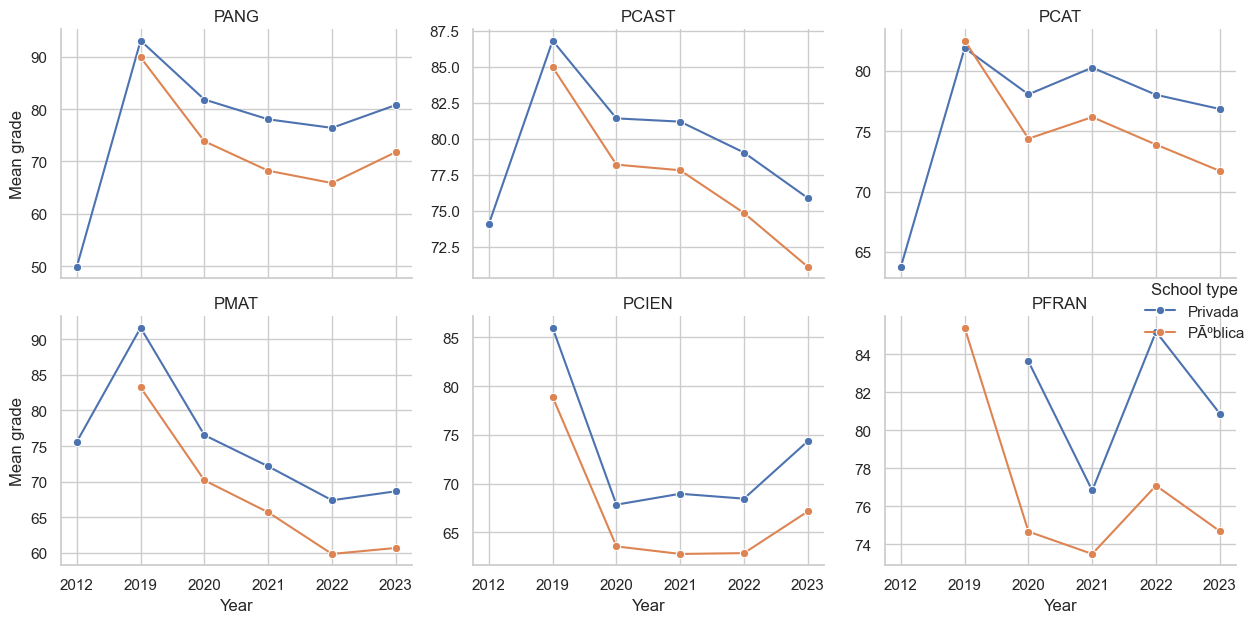

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# -------------------------------------------------
# 1. CONFIGURING NAMES TO MATCH THE DATA
# -------------------------------------------------

df = df_S_unique  # or df_P_unique, or a merged one

# Column that indicates school type (public/private)
school_type_col = "NATURALESA" 

# Column that indicates year
year_col = "ANY"          

# Subjects in secondary you want to include (adapt as needed)
grade_cols = ['PCAT', 'PCAST', 'PMAT', 'PANG', 'PFRAN', 'PCIEN']

# -------------------------------------------------
# 2. Ensure grades are numeric and keep only needed columns
# -------------------------------------------------

# Work on a copy to avoid modifying original
df_plot = df.copy()

# Convert chosen grade columns to numeric (handle commas)
for col in grade_cols:
    if col in df_plot.columns:
        s = df_plot[col].astype(str).str.replace(",", ".", regex=False)
        df_plot[col] = pd.to_numeric(s, errors="coerce")
    else:
        print(f"Warning: column {col} not found in DataFrame.")

# Drop rows where school type or year is missing
df_plot = df_plot.dropna(subset=[school_type_col, year_col])

# -------------------------------------------------
# 3. Reshape to long format: one row per (student, subject)
# -------------------------------------------------

# Keep only existing subject columns
existing_grade_cols = [c for c in grade_cols if c in df_plot.columns]

long_df = df_plot[[school_type_col, year_col] + existing_grade_cols].melt(
    id_vars=[school_type_col, year_col],
    value_vars=existing_grade_cols,
    var_name="subject",
    value_name="grade"
)

# Remove rows with missing grades
long_df = long_df.dropna(subset=["grade"])

# -------------------------------------------------
# 4. Compute mean grades by (school type, year, subject)
# -------------------------------------------------

mean_df = (
    long_df
    .groupby([school_type_col, year_col, "subject"], as_index=False)["grade"]
    .mean()
)

# If year is numeric, sort by it
if pd.api.types.is_numeric_dtype(mean_df[year_col]):
    mean_df = mean_df.sort_values(year_col)

# -------------------------------------------------
# 5. Plot: one facet per subject, lines for public vs private
# -------------------------------------------------

g = sns.FacetGrid(
    mean_df,
    col="subject",
    hue=school_type_col,
    col_wrap=3,
    sharey=False,
    height=3.2,
    aspect=1.2
)

g.map_dataframe(
    sns.lineplot,
    x=year_col,
    y="grade",
    marker="o"
)

g.add_legend(title="School type")

g.set_axis_labels("Year", "Mean grade")
g.set_titles("{col_name}")

plt.tight_layout()
plt.show()